In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os

In [ ]:
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [ ]:
dfpath = os.path.join("/content/drive/MyDrive/farmworks_data_241208.xlsx")
df = pd.read_excel(dfpath)
df.head()

,timestamp,date,year,month,day,day_of_week,hour,item,qty,gross_sale,discount,net_sales,tax,salad_qty,emp_qty,soup_qty,soup_enc,salad_enc,emp_enc,rain
0,2023-09-01 11:04:07,2023-09-01,2023,9,1,0,11,Soup - Non-Dickinson Student or Non-Meal Plan,1,5.0,0.0,5.0,0.3,0.0,0,1.0,8,10,6,0
1,2023-09-01 11:04:36,2023-09-01,2023,9,1,0,11,Soup - Dickinson Student w. Meal Plan,1,3.0,0.0,3.0,0.0,0.0,0,1.0,8,10,6,0
2,2023-09-01 11:05:24,2023-09-01,2023,9,1,0,11,1/2 Soup - 1/2 Salad - Dickinson Student w. Me...,1,3.0,0.0,3.0,0.0,0.5,0,0.5,8,10,6,0
3,2023-09-01 11:06:12,2023-09-01,2023,9,1,0,11,Soup - Dickinson Student w. Meal Plan,1,3.0,0.0,3.0,0.0,0.0,0,1.0,8,10,6,0
4,2023-09-01 11:06:46,2023-09-01,2023,9,1,0,11,Soup - Dickinson Student w. Meal Plan,1,3.0,0.0,3.0,0.0,0.0,0,1.0,8,10,6,0


In [ ]:
agg_functions = {
    'salad_qty': 'sum',
    'soup_qty': 'sum',
    'emp_qty': 'sum',
    'salad_enc': 'mean',
    'soup_enc': 'mean',
    'emp_enc': 'mean',
    'rain': 'mean'
}

df = df.groupby(['year', 'month', 'day', 'day_of_week', 'hour']).agg(agg_functions).reset_index()

df.head()

,year,month,day,day_of_week,hour,salad_qty,soup_qty,emp_qty,salad_enc,soup_enc,emp_enc,rain
0,2023,9,1,0,11,10.0,16.0,0,10.0,8.0,6.0,0.0
1,2023,9,1,0,12,16.0,23.0,0,10.0,8.0,6.0,0.0
2,2023,9,1,0,13,4.5,9.5,0,10.0,8.0,6.0,0.0
3,2023,9,4,1,11,14.5,13.5,0,3.0,11.0,6.0,0.0
4,2023,9,4,1,12,14.5,17.5,0,3.0,11.0,6.0,0.0


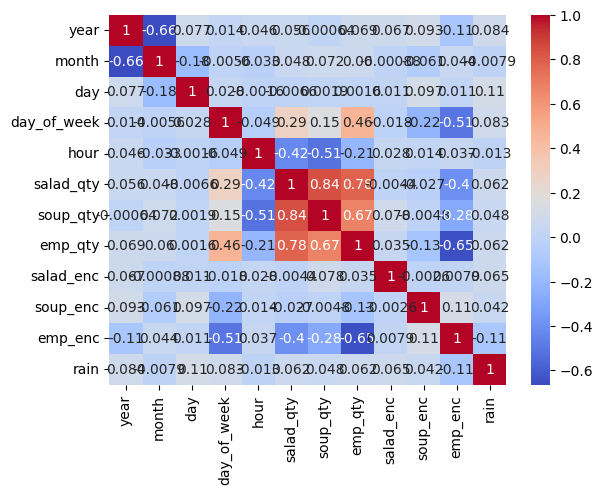

In [ ]:
# Visualize correlations
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Specify the features (X) and the target (y)
X = df[['day_of_week', 'hour', 'salad_enc', 'soup_enc', 'emp_enc', 'rain']]
y = df[['salad_qty', 'soup_qty', 'emp_qty']]

#Keep a copy of features for plotting
features = X.columns

X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (547, 6)
y shape: (547, 3)
[[ 0. 11. 10.  8.  6.  0.]
 [ 0. 12. 10.  8.  6.  0.]
 [ 0. 13. 10.  8.  6.  0.]
 ...
 [ 3. 11.  4.  6.  5.  0.]
 [ 3. 12.  4.  6.  5.  0.]
 [ 3. 13.  4.  6.  5.  0.]]
[[10.  16.   0. ]
 [16.  23.   0. ]
 [ 4.5  9.5  0. ]
 ...
 [39.  48.  87. ]
 [22.  23.  45. ]
 [ 6.5  7.5 14. ]]


In [ ]:
# Initialize the multi-output regression model
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')  # Per target
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')  # Overall R^2

# Display evaluation metrics
print("Mean Squared Error (per target):", mse)
print("Overall R² Score:", r2)

Mean Squared Error (per target): [ 49.25507916  70.81623246 281.79935805]
Overall R² Score: 0.38950898576412796


In [ ]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("Baseline Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

Baseline Cross-Validation R² Scores: [0.20989333 0.35690596 0.41348696 0.40236881 0.3354426 ]
Mean R²: 0.3436195305190644


Scaling the features for linear regression

In [ ]:
# Initialize the scaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Linear Regression
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')  # Per target
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')  # Overall

print("Mean Squared Error (per target):", mse)
print("Overall R² Score:", r2)


Mean Squared Error (per target): [ 49.25507916  70.81623246 281.79935805]
Overall R² Score: 0.3895089857641282


Scaling didn't help.
Going to implement randomForestRegressor

In [ ]:
# Specify the features (X) and the target (y)
X = df[['day_of_week', 'hour', 'salad_enc', 'soup_enc', 'emp_enc', 'rain']]
y = df[['salad_qty', 'soup_qty', 'emp_qty']]

X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (547, 6)
y shape: (547, 3)
[[ 0. 11. 10.  8.  6.  0.]
 [ 0. 12. 10.  8.  6.  0.]
 [ 0. 13. 10.  8.  6.  0.]
 ...
 [ 3. 11.  4.  6.  5.  0.]
 [ 3. 12.  4.  6.  5.  0.]
 [ 3. 13.  4.  6.  5.  0.]]
[[10.  16.   0. ]
 [16.  23.   0. ]
 [ 4.5  9.5  0. ]
 ...
 [39.  48.  87. ]
 [22.  23.  45. ]
 [ 6.5  7.5 14. ]]


In [ ]:
# Step 3: Train the Random Forest Regressor
fr_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
fr_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_fr = fr_model.predict(X_test)

# Step 5: Evaluate the model
mse_fr = mean_squared_error(y_test, y_pred_fr, multioutput='raw_values')  # Per target
r2_fr = r2_score(y_test, y_pred_fr , multioutput='variance_weighted')  # Overall R²

print("Forest MSE:", mse_fr)
print("Forest R²:", r2_fr)

Forest MSE: [25.86155633 50.27585584 77.25915756]
Forest R²: 0.7669717287141031


In [ ]:
cv_scores = cross_val_score(fr_model, X, y, cv=5, scoring='r2')

print("Baseline Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

Baseline Cross-Validation R² Scores: [0.78453188 0.52415703 0.71953488 0.56824369 0.28315475]
Mean R²: 0.5759244445372147


Score looks better. Going to further interpret the score wtih residual and feature importance

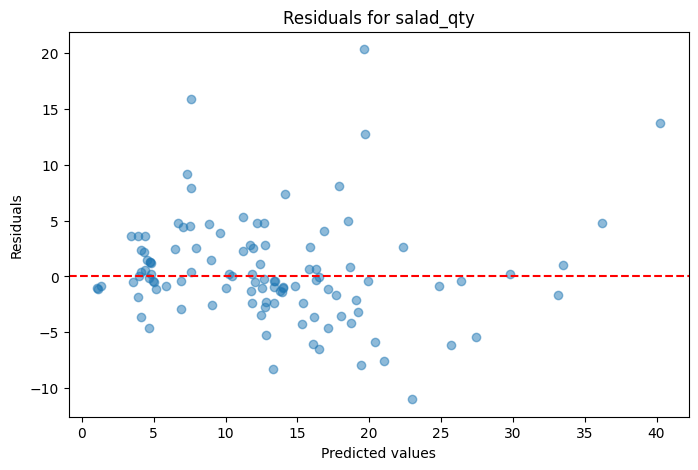

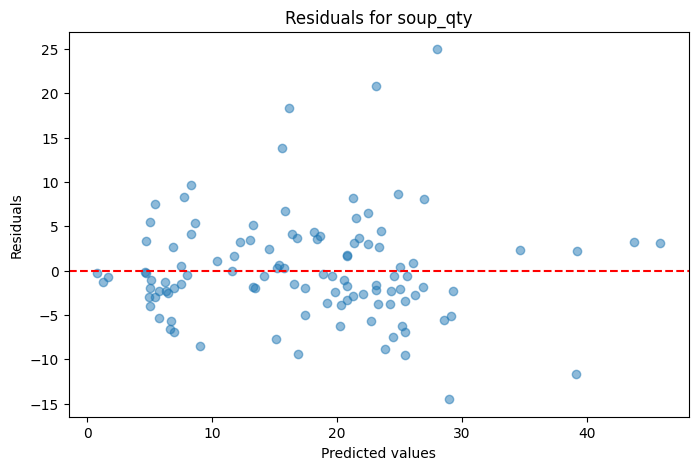

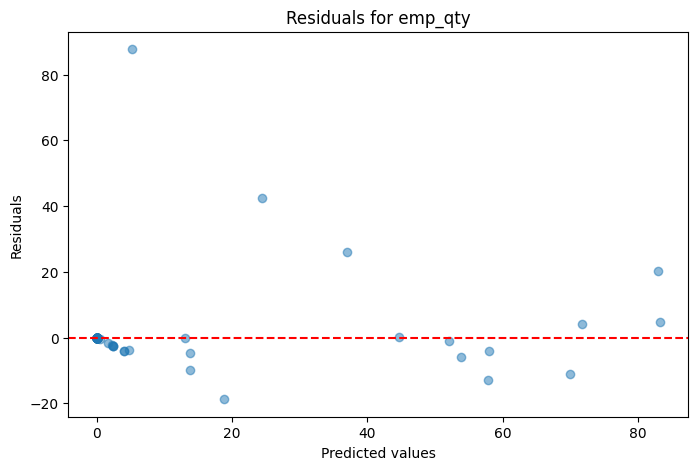

In [ ]:
residuals = y_test - y_pred_rf
target_names = ['salad_qty', 'soup_qty', 'emp_qty']  # Define target names here
for i, target in enumerate(target_names): # Iterate over target names
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_rf[:, i], residuals[:, i], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals for {target}')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

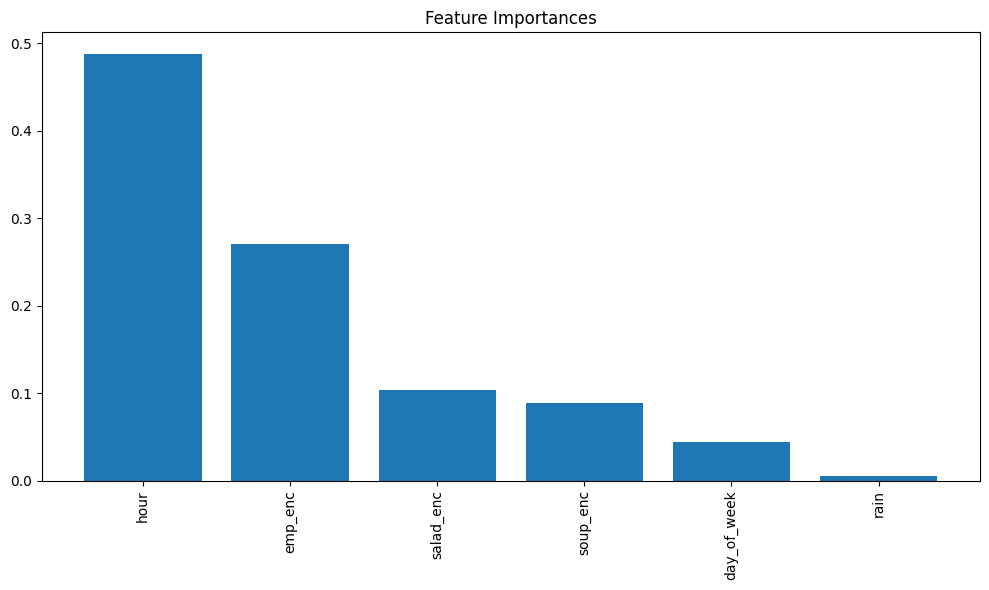

In [ ]:
importances = fr_model.estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]
# features = X.columns # This line caused the error
# Use the features list created before converting to numpy array

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90) #use the features list created before
plt.tight_layout()
plt.show()


Hyperpaprameter TUning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}
random_search = RandomizedSearchCV(
    estimator=fr_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 30}
Best R^2 Score: 0.70756495822753


Learning Curve Analysis

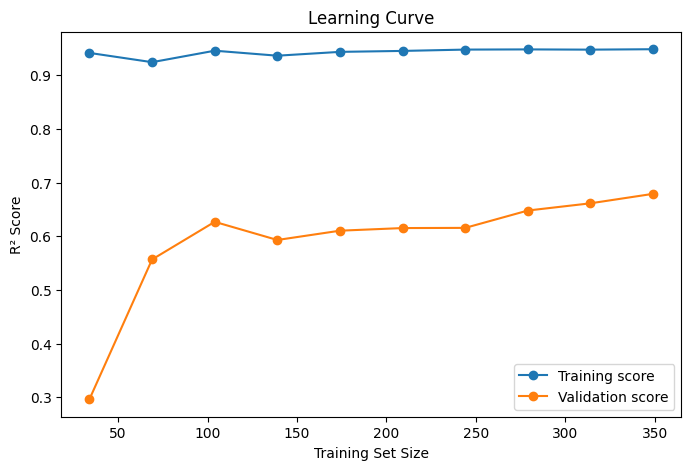

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    fr_model,
    X_train,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Validation score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()


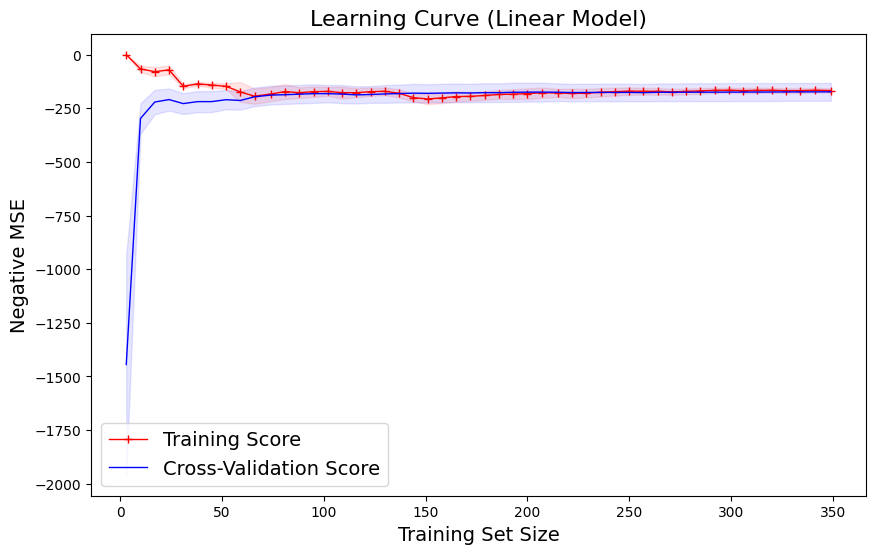

In [ ]:
# Generate cross-validated training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(),
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.01, 1.0, 50),
    n_jobs=-1
)

# Calculate means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=1, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=1, label="Cross-Validation Score")
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1, color="red")
plt.fill_between(train_sizes,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.1, color="blue")
plt.legend(loc="best", fontsize=14)
plt.xlabel("Training Set Size", fontsize=14)
#plt.ylim(-50,0)
plt.ylabel("Negative MSE", fontsize=14)
plt.title("Learning Curve (Linear Model)", fontsize=16)
plt.show()


Feature enginerring

In [ ]:
# Add interaction features
df['hour_day_interaction'] = df['hour'] * df['day_of_week']
df['rain_soup_interaction'] = df['rain'] * df['soup_enc']

# Add rolling averages and lag features (e.g., for salad_qty)
df['salad_qty_rolling_3'] = df['salad_qty'].rolling(window=3, min_periods=1).mean()
df['soup_qty_rolling_3'] = df['soup_qty'].rolling(window=3, min_periods=1).mean()

df['salad_qty_lag_1'] = df['salad_qty'].shift(1)
df['soup_qty_lag_1'] = df['soup_qty'].shift(1)

# Fill missing values after adding lag features
df.fillna(0, inplace=True)
df.head()

,year,month,day,day_of_week,hour,salad_qty,soup_qty,emp_qty,salad_enc,soup_enc,emp_enc,rain,hour_day_interaction,rain_soup_interaction,salad_qty_rolling_3,soup_qty_rolling_3,salad_qty_lag_1,soup_qty_lag_1
0,2023,9,1,0,11,10.0,16.0,0,10.0,8.0,6.0,0.0,0,0.0,10.000000,16.000000,0.0,0.0
1,2023,9,1,0,12,16.0,23.0,0,10.0,8.0,6.0,0.0,0,0.0,13.000000,19.500000,10.0,16.0
2,2023,9,1,0,13,4.5,9.5,0,10.0,8.0,6.0,0.0,0,0.0,10.166667,16.166667,16.0,23.0
3,2023,9,4,1,11,14.5,13.5,0,3.0,11.0,6.0,0.0,11,0.0,11.666667,15.333333,4.5,9.5
4,2023,9,4,1,12,14.5,17.5,0,3.0,11.0,6.0,0.0,12,0.0,11.166667,13.500000,14.5,13.5


In [ ]:
# Define features and targets
X = df[['day_of_week', 'hour', 'salad_enc', 'soup_enc', 'emp_enc', 'rain',
          'hour_day_interaction', 'rain_soup_interaction',
          'salad_qty_rolling_3', 'soup_qty_rolling_3',
          'salad_qty_lag_1', 'soup_qty_lag_1']]
y = df[['salad_qty', 'soup_qty', 'emp_qty']]

#Keep a copy of features for plotting
features = X.columns

X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (547, 12)
y shape: (547, 3)
[[ 0.         11.         10.         ... 16.          0.
   0.        ]
 [ 0.         12.         10.         ... 19.5        10.
  16.        ]
 [ 0.         13.         10.         ... 16.16666667 16.
  23.        ]
 ...
 [ 3.         11.          4.         ... 26.66666667  4.5
   6.5       ]
 [ 3.         12.          4.         ... 25.83333333 39.
  48.        ]
 [ 3.         13.          4.         ... 26.16666667 22.
  23.        ]]
[[10.  16.   0. ]
 [16.  23.   0. ]
 [ 4.5  9.5  0. ]
 ...
 [39.  48.  87. ]
 [22.  23.  45. ]
 [ 6.5  7.5 14. ]]


In [ ]:
# Initialize the multi-output regression model
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')  # Per target
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')  # Overall R^2

# Display evaluation metrics
print("Mean Squared Error (per target):", mse)
print("Overall R² Score:", r2)

Mean Squared Error (per target): [ 34.62299592  46.93012781 241.25725384]
Overall R² Score: 0.5096113011490934


In [ ]:
# Initialize the scaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Linear Regression
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')  # Per target
r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')  # Overall

print("Mean Squared Error (per target):", mse)
print("Overall R² Score:", r2)


Mean Squared Error (per target): [ 34.62299592  46.93012781 241.25725384]
Overall R² Score: 0.5096113011490929


Scaling didn't improve anything.

In [ ]:
# Define features and targets
X = df[['day_of_week', 'hour', 'salad_enc', 'soup_enc', 'emp_enc', 'rain',
          'hour_day_interaction', 'rain_soup_interaction',
          'salad_qty_rolling_3', 'soup_qty_rolling_3',
          'salad_qty_lag_1', 'soup_qty_lag_1']]
y = df[['salad_qty', 'soup_qty', 'emp_qty']]

#Keep a copy of features for plotting
features = X.columns

X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (547, 12)
y shape: (547, 3)
[[ 0.         11.         10.         ... 16.          0.
   0.        ]
 [ 0.         12.         10.         ... 19.5        10.
  16.        ]
 [ 0.         13.         10.         ... 16.16666667 16.
  23.        ]
 ...
 [ 3.         11.          4.         ... 26.66666667  4.5
   6.5       ]
 [ 3.         12.          4.         ... 25.83333333 39.
  48.        ]
 [ 3.         13.          4.         ... 26.16666667 22.
  23.        ]]
[[10.  16.   0. ]
 [16.  23.   0. ]
 [ 4.5  9.5  0. ]
 ...
 [39.  48.  87. ]
 [22.  23.  45. ]
 [ 6.5  7.5 14. ]]


In [ ]:
# Step 3: Train the Random Forest Regressor
fr_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
fr_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred_fr = fr_model.predict(X_test)

# Step 5: Evaluate the model
mse_fr = mean_squared_error(y_test, y_pred_fr, multioutput='raw_values')  # Per target
r2_fr = r2_score(y_test, y_pred_fr , multioutput='variance_weighted')  # Overall R²

print("Forest MSE:", mse_fr)
print("Forest R²:", r2_fr)

Forest MSE: [ 21.64520682  35.13288386 104.58902727]
Forest R²: 0.7548634848507958


In [ ]:
cv_scores = cross_val_score(fr_model, X, y, cv=5, scoring='r2')

print("Baseline Cross-Validation R² Scores:", cv_scores)
print("Mean R²:", cv_scores.mean())

Baseline Cross-Validation R² Scores: [0.84514987 0.76337566 0.884405   0.80893489 0.41800995]
Mean R²: 0.7439750735540771


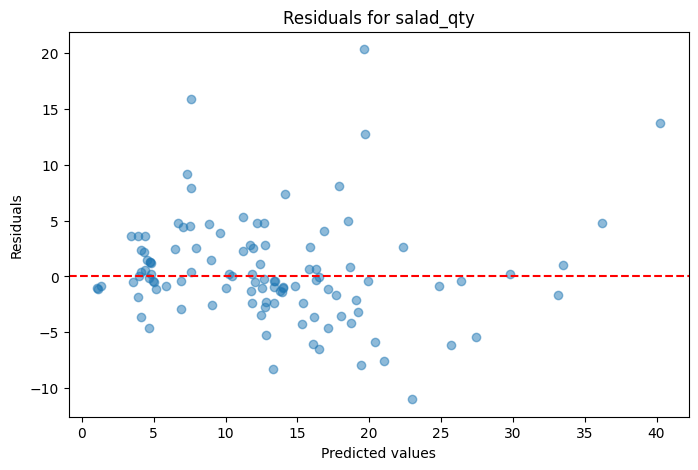

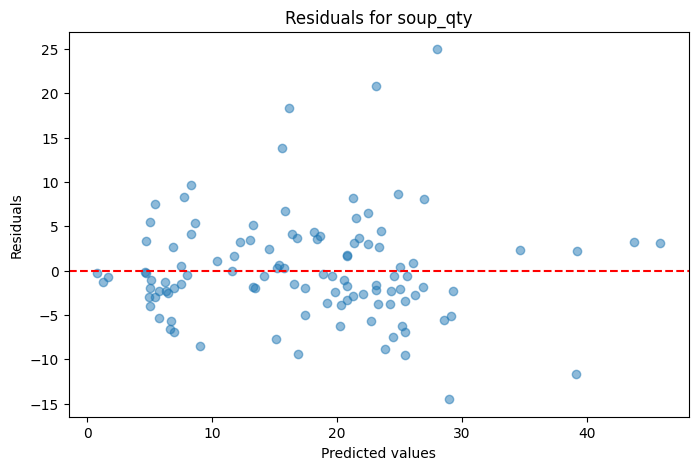

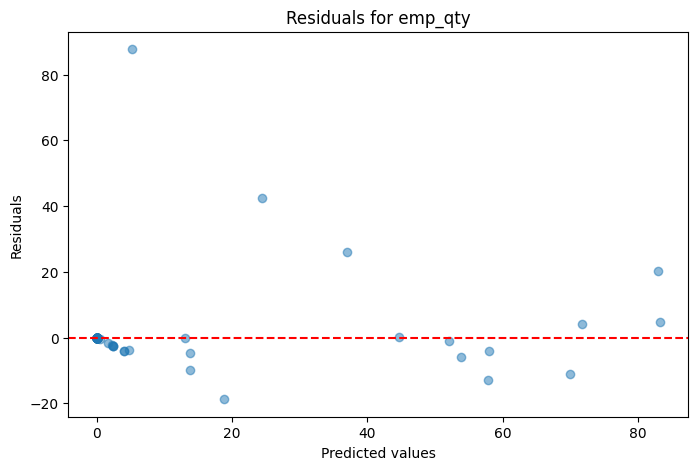

In [ ]:
residuals = y_test - y_pred_rf
target_names = ['salad_qty', 'soup_qty', 'emp_qty']  # Define target names here
for i, target in enumerate(target_names): # Iterate over target names
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_rf[:, i], residuals[:, i], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals for {target}')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

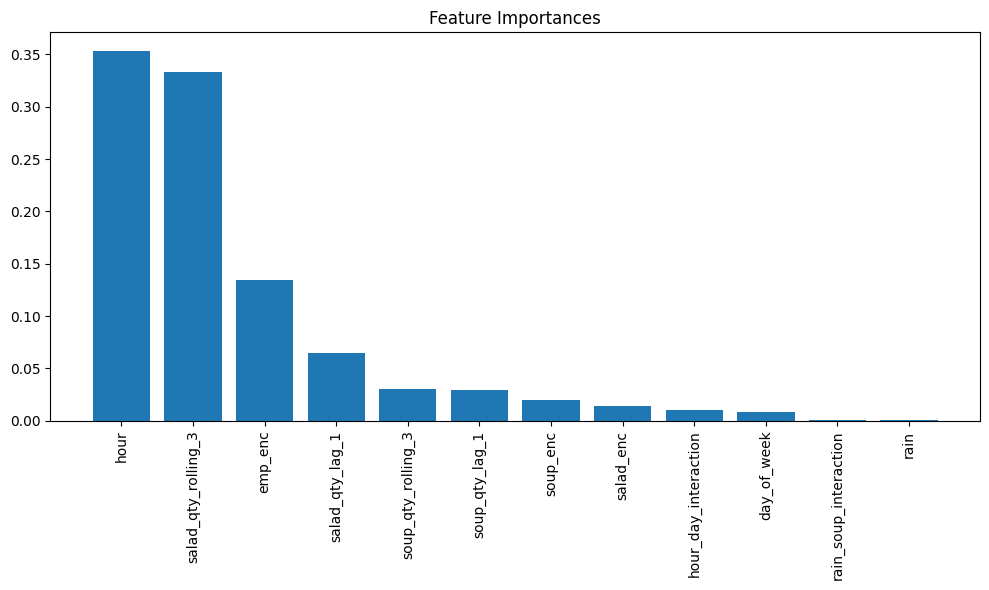

In [ ]:
importances = fr_model.estimators_[0].feature_importances_
indices = np.argsort(importances)[::-1]
# features = X.columns # This line caused the error
# Use the features list created before converting to numpy array

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90) #use the features list created before
plt.tight_layout()
plt.show()


In [ ]:
param_dist = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
}
random_search = RandomizedSearchCV(
    estimator=fr_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best R^2 Score:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'estimator__n_estimators': 300, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 30}
Best R^2 Score: 0.8430442178532589


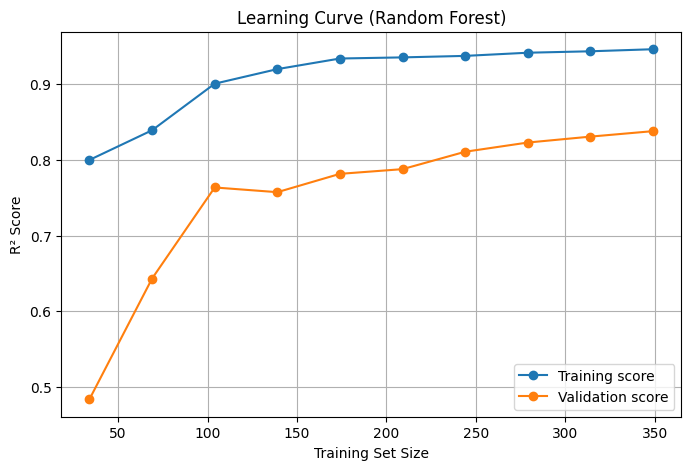

In [ ]:
# Retrieve the best estimator for further analysis
best_fr_model = random_search.best_estimator_

# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_fr_model,  # Use the best model from RandomizedSearchCV
    X_train,
    y_train,
    cv=5,  # Cross-validation folds
    scoring='r2',  # Metric to evaluate
    n_jobs=-1,  # Use all processors
    train_sizes=np.linspace(0.1, 1.0, 10)  # Vary training sizes
)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Validation score")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()


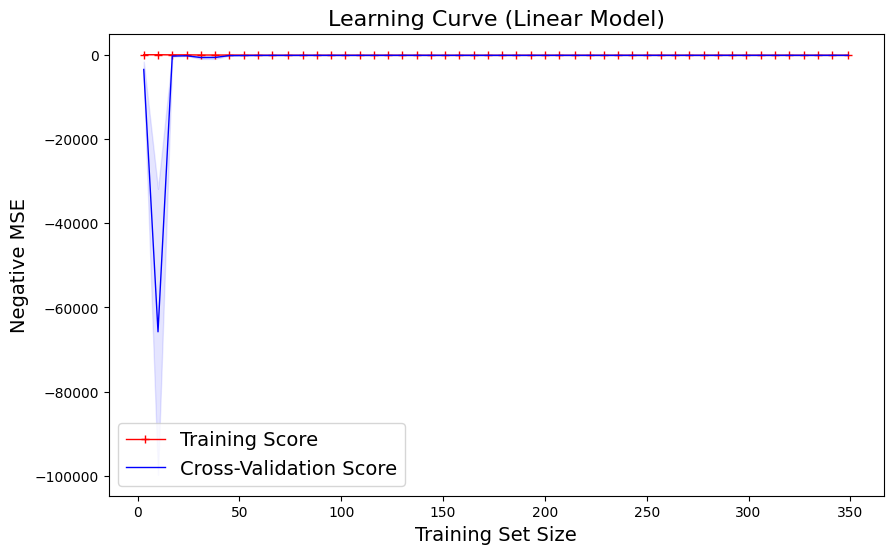

In [ ]:
# Generate cross-validated training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(
    LinearRegression(),
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.01, 1.0, 50),
    n_jobs=-1
)

# Calculate means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=1, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=1, label="Cross-Validation Score")
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1, color="red")
plt.fill_between(train_sizes,
                 val_mean - val_std,
                 val_mean + val_std,
                 alpha=0.1, color="blue")
plt.legend(loc="best", fontsize=14)
plt.xlabel("Training Set Size", fontsize=14)
#plt.ylim(-50,0)
plt.ylabel("Negative MSE", fontsize=14)
plt.title("Learning Curve (Linear Model)", fontsize=16)
plt.show()
